In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
pd.options.display.max_rows = 10
pd.options.display.max_columns = 6

### Functions

In [2]:
def replace_labels(ax, char, axis='y'):
    # Customize y-labels
    if axis == 'x':
        _ = ticks_loc = ax.get_xticks().tolist()
        _ = ax.set_xticks(ticks_loc)
        _ = ax.set_xticklabels([f'{x:,.0f}{char}' for x in ticks_loc])
    if axis == 'y':
        _ = ticks_loc = ax.get_yticks().tolist()
        _ = ax.set_yticks(ticks_loc)
        _ = ax.set_yticklabels([f'{x:,.0f}{char}' for x in ticks_loc])
    
def perfom_anderson_test(data):
	result = anderson(data)
	print('Statistic = %.2f' % result.statistic)

	p = 0
	for i in range(len(result.critical_values)):
		sl, cv = result.significance_level[i], result.critical_values[i]
		if result.statistic < result.critical_values[i]:
			print(f'significance level = {sl:.2f}, critical value = {cv:.2f}, (fail to reject H0)')
		else:
			print(f'significance level = {sl:.2f}, critical value = {cv:.2f}, (reject H0)')
	print('\n')


### Import dataset


In [3]:
df = pd.read_csv("../data/raw/train.csv")

### Explore data

This dataset has:

5 discrete numerical variables: *PassengerId, Survived, Pclass, SibSp, Parch*

2 numerical continuous variables: *Age, Fare*

5 categorical variables: *Name, Sex, Ticket, Cabin, Embarked*

In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The data seems to haven't erroneous values, like negative *Age, Parch* or *Fare*

In [5]:

df.describe()

,PassengerId,Survived,Pclass,...,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,...,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,...,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,...,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,...,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,...,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,...,8.000000,6.000000,512.329200


In [6]:

df.head()

,PassengerId,Survived,Pclass,...,Fare,Cabin,Embarked
0,1,0,3,...,7.2500,NaN,S
1,2,1,1,...,71.2833,C85,C
2,3,1,3,...,7.9250,NaN,S
3,4,1,1,...,53.1000,C123,S
4,5,0,3,...,8.0500,NaN,S


In [7]:

df.tail()

,PassengerId,Survived,Pclass,...,Fare,Cabin,Embarked
886,887,0,2,...,13.00,NaN,S
887,888,1,1,...,30.00,B42,S
888,889,0,3,...,23.45,NaN,S
889,890,1,1,...,30.00,C148,C
890,891,0,3,...,7.75,NaN,Q


The *Cabin* feature has many missing values, maybe be unuseful to model.

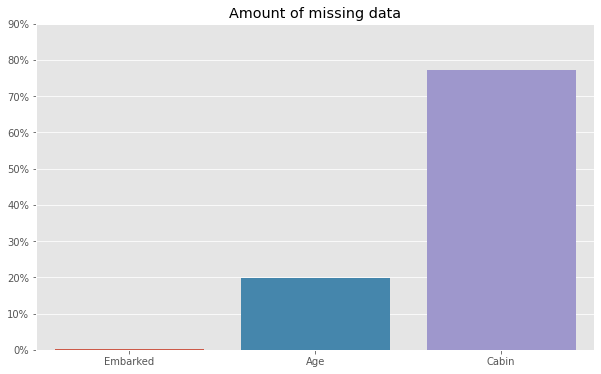

In [8]:

# Get  only columns with missing data
missing_data = (df.isnull().sum() / len(df)) *100
missing_data = missing_data[missing_data > 0].sort_values()
missing_data

# Plot data
g = sns.barplot(x=missing_data.index, y=missing_data.values)
g.set_title('Amount of missing data')

# Replace y-axis labels
replace_labels(g,'%')

### Analysing Survivors

Grouping survivors by class we see that on average 63% of the passengers of the 1st class survived, 47.23% of the 2nd and only 24.24% in the 3rd.

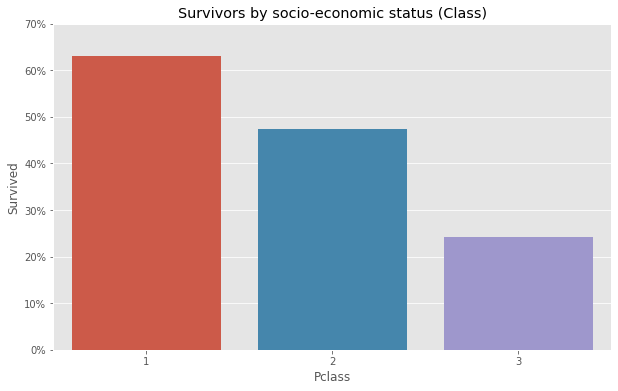

In [9]:

pclass_surv = df[["Survived", "Pclass"]].groupby("Pclass", as_index=False).mean()

g = sns.barplot(x=pclass_surv['Pclass'], y=pclass_surv['Survived']*100)
g.set_title('Survivors by socio-economic status (Class)')

replace_labels(g, '%')


On average 74% of the women survived against roughly 19% of the men.

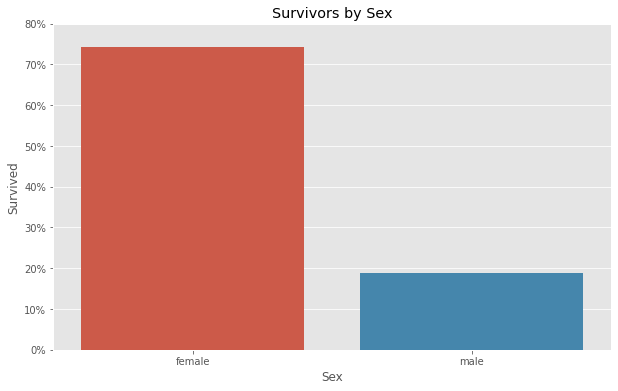

In [10]:

sex_surv = df[["Survived", "Sex"]].groupby("Sex", as_index=False).mean()
g = sns.barplot(x=sex_surv["Sex"], y=sex_surv["Survived"]*100)
g.set_title('Survivors by Sex')
replace_labels(g, '%')

People accompanied by spouses, brother, sister, stepbrother, stepsister, or accompanied by at least three relatives had more chance of surviving.

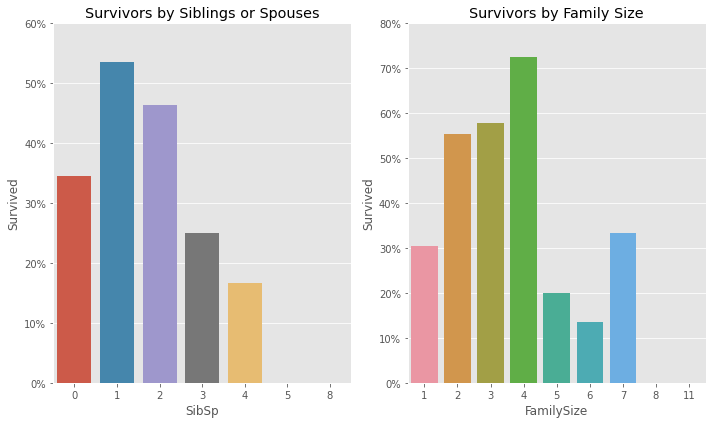

In [11]:

surv_family = df[["Survived", "SibSp"]].groupby("SibSp", as_index=False).mean()

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
surv_sibsp = df[["Survived", "FamilySize"]].groupby("FamilySize", as_index=False).mean()


_, axs = plt.subplots(1,2)

g0 = sns.barplot(x=surv_family["SibSp"], y=surv_family["Survived"]*100, ax=axs[0])
g0.set_title('Survivors by Siblings or Spouses')
replace_labels(g0, '%')

g1 = sns.barplot(x=surv_sibsp["FamilySize"], y=surv_sibsp["Survived"]*100)
g1.set_title('Survivors by Family Size')
replace_labels(g1, '%')

plt.tight_layout()

Alone people survived less

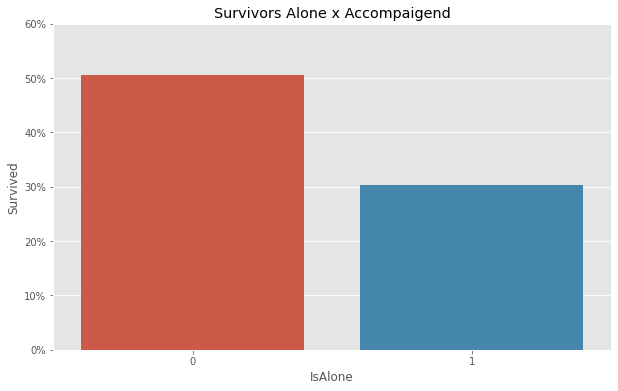

In [12]:

df["IsAlone"] = 0
df.loc[df["FamilySize"] == 1, "IsAlone"] = 1
surv_alone = df[["Survived", "IsAlone"]].groupby(["IsAlone"], as_index=False).mean()
g = sns.barplot(x=surv_alone["IsAlone"], y=surv_alone["Survived"]*100)
g.set_title("Survivors Alone x Accompaigend")
replace_labels(g, "%")

On average more people who embarked in Cherbourg survived. <br>
('Cherbourg, Q = Queenstown, S = Southampton')

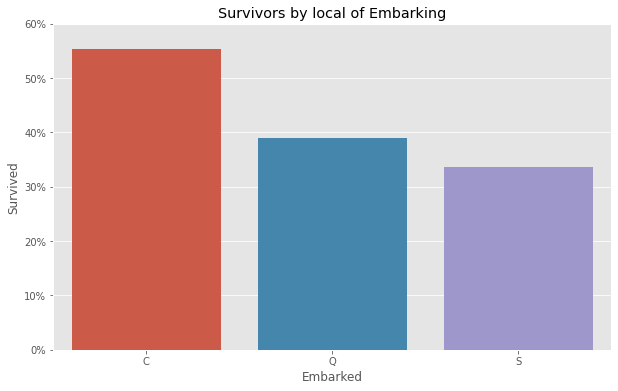

In [13]:

surv_embarked = df[["Survived", "Embarked"]].groupby("Embarked", as_index=False).mean()
g = sns.barplot(x=surv_embarked["Embarked"], y=surv_embarked["Survived"]*100)
g.set_title('Survivors by local of Embarking')
replace_labels(g, '%')

We can discretize the Fare data into bands, and analyze how the survivors distributed along it

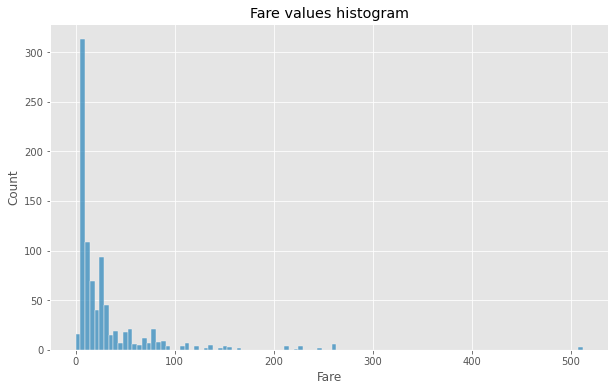

In [14]:

g = sns.histplot(x=df['Fare'])
_ = g.set_title("Fare values histogram")

In [15]:
pd.qcut(df['Fare'], 4, precision=2)

0       (-0.01, 7.91]
1      (31.0, 512.33]
2       (7.91, 14.45]
3      (31.0, 512.33]
4       (7.91, 14.45]
            ...      
886     (7.91, 14.45]
887     (14.45, 31.0]
888     (14.45, 31.0]
889     (14.45, 31.0]
890     (-0.01, 7.91]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64, right]): [(-0.01, 7.91] < (7.91, 14.45] < (14.45, 31.0] < (31.0, 512.33]]

Rich people, as also shown by Pclass plot, have survived more.

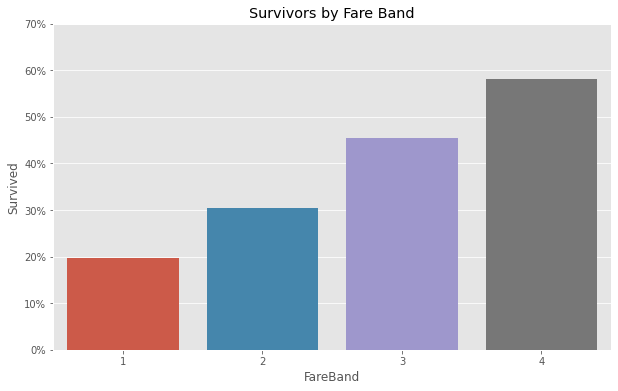

In [16]:

df['FareBand'] = pd.qcut(df['Fare'], 4, labels=[1, 2, 3, 4])
surv_fare = df[["Survived", "FareBand"]].groupby("FareBand", as_index=False).mean()
g = sns.barplot(x=surv_fare["FareBand"], y=surv_fare["Survived"]*100)
g.set_title('Survivors by Fare Band')
replace_labels(g, '%')

Before analyzing the ages, we need to fill in a few missing values. If the data followed the normal distribution, the mean would be a good guess, but this is not the case, as you can see by the Anderson test result.

In [17]:
print("Null hypothesis (H0): Sons heights follows the normal curve")
perfom_anderson_test(df['Age'].dropna())


Null hypothesis (H0): Sons heights follows the normal curve
Statistic = 3.82
significance level = 15.00, critical value = 0.57, (reject H0)
significance level = 10.00, critical value = 0.65, (reject H0)
significance level = 5.00, critical value = 0.78, (reject H0)
significance level = 2.50, critical value = 0.91, (reject H0)
significance level = 1.00, critical value = 1.09, (reject H0)




So, i will use the KKNinputer to fill data.

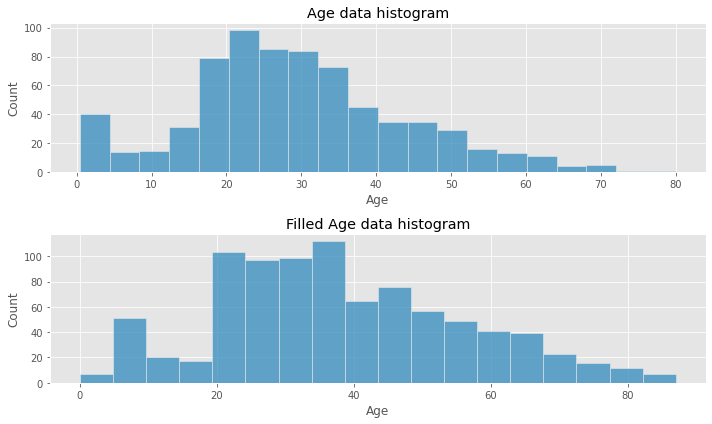

In [18]:

_, ax = plt.subplots(2,1)

# Save the old value of Age data
old_data =  df['Age']

# Encode string as numeric values
enc = OrdinalEncoder()
df[['Pclass','Sex','Age','FareBand','Embarked']] = enc.fit_transform(df[['Pclass','Sex','Age','FareBand','Embarked']])

# Input data based on KNN
imputer = KNNImputer(n_neighbors=2)
df[['Pclass','Sex','Age','FareBand','Embarked']]= imputer.fit_transform(df[['Pclass','Sex','Age','FareBand','Embarked']])

g0 = sns.histplot(old_data, ax=ax[0])
_ = g0.set_title('Age data histogram')

g1 = sns.histplot(df['Age'], ax=ax[1])
_ = g1.set_title('Filled Age data histogram')

plt.tight_layout()

Children and Youth survived more

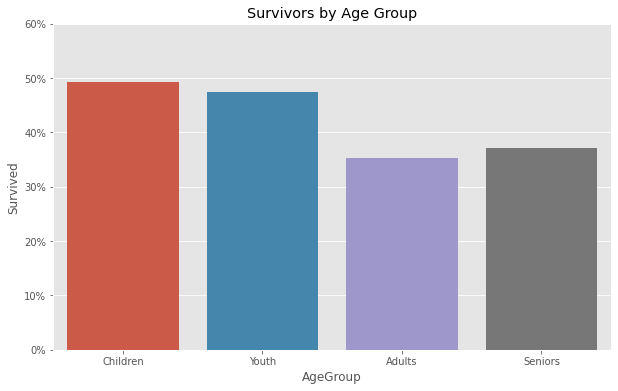

In [20]:

df['AgeGroup'] = pd.cut(df['Age'], [0,14,24,64, 150], labels=['Children','Youth','Adults','Seniors'])
surv_agegroup = df[["Survived", "AgeGroup"]].groupby("AgeGroup", as_index=False).mean()
g = sns.barplot(x=surv_agegroup["AgeGroup"], y=surv_agegroup["Survived"]*100)
_ = g.set_title('Survivors by Age Group')
replace_labels(g, '%')